# Analyzing tweets with NLP using Spark and Twint


How to get tweets data using Twint and PySpark

In [ ]:
%load_ext autoreload
%autoreload 2

# Import twint
import sys
sys.path.append("twint/")


# Set up TWINT config
import twint
c = twint.Config()

# Other imports
import seaborn as sns
import os

# Solve compatibility issues with notebooks and RunTime errors
import nest_asyncio
nest_asyncio.apply()

# Disable annoying printing
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull,"w")
        
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import re
import networkx as nx


import nltk
nltk.download(['punkt','stopwords'])
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

from nltk import bigrams

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
%config InlineBackend.figure_format = 'retina'

[nltk_data] Downloading package punkt to /Users/anhpham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anhpham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


There are 2 popular choices when it comes to libraries to perform sentiment analysis: VADER and TextBlob

Vader Sentiment Analysis works better with texts from social media and in generalas well. It is based on lexicons of sentiment-related words. Each words in the lexicon israted whether it is positive or negative. When it comes to analysing comments or text from social media, the sentiment of the sentence changes based on the emoticons as well. Vader takes this into account along with slang, capitalization and hence a better option when it comes to tweets analysis and their sentiments. 

In [103]:
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkContext
spark = SparkSession.builder.getOrCreate()

analyzer = SentimentIntensityAnalyzer()

tweet_cols = ["id", "date", "tweet", "hashtags", "nlikes"];

# # Function to get sentiment   
# def apply_blob(sentence):
#     temp = TextBlob(sentence).sentiment[0]
#     if temp ==0:
#         return 0.0 # Neutral
#     elif temp >= 0.0:
#         return 1.0 # Positive
#     else:
#         return 2.0 # Negative
    
def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
    return score['compound']

# UDF to write sentiment on DF
# sentiment = udf(apply_blob, DoubleType())
sentiment = udf(sentiment_analyzer_scores, DoubleType())


# Transform result to pandas
def twint_to_pandas(columns):
    return twint.output.panda.Tweets_df[columns]

def tweets_sentiment(search, limit=1):
    c.Search = search
    # Custom output format
    c.Limit = limit
    c.Pandas = True
    with HiddenPrints():
        print(twint.run.Search(c))
        
    # Transform tweets to pandas DF
    df_pd = twint_to_pandas(tweet_cols) 
    
    # Transfrom Pandas DF to Spark df
    df = spark.createDataFrame(df_pd) 
    
    # Clean tweets
    clean_tweets = df.dropDuplicates() ## TO DO: add in more data cleaning steps here.
    
#     clean_tweets['vader_score'] = clean_tweets['tweet'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    # Add sentiment to final DF
    return clean_tweets.withColumn("sentiment", sentiment(clean_tweets['tweet']))
    

In [104]:
df_result = tweets_sentiment("depression",limit= 1)

df_result.show()

+-------------------+-------------------+--------------------+--------------------+------+---------+
|                 id|               date|               tweet|            hashtags|nlikes|sentiment|
+-------------------+-------------------+--------------------+--------------------+------+---------+
|1297441641888915456|2020-08-23 15:52:47|Moi aussi je cons...|                  []|     0|      0.0|
|1297441639590486016|2020-08-23 15:52:46|If Nakyum dies, I...|                  []|     1|  -0.5719|
|1297441682049335297|2020-08-23 15:52:56|Get your doctor t...|                  []|     0|   -0.743|
|1297441713800335361|2020-08-23 15:53:04|Me this morning: ...|                  []|     0|   0.0511|
|1297441810462244864|2020-08-23 15:53:27|His tail swayed a...|                  []|     0|      0.0|
|1297441799993274368|2020-08-23 15:53:25|this whole quaran...|                  []|     0|   -0.037|
|1297441742661267456|2020-08-23 15:53:11|Katy Perry opens ...|                  []|     0| 

Use the function above to generate the dataset consists of other depressive search terms and combine separate datasets into one

In [113]:
depressive_terms = ['hopeless','anxious','suicide','lonely','antidepressant']

limit = 10000

depressive_twint_tweets_df =  tweets_sentiment("depression",limit=limit)

for term in depressive_terms:
    df_term = tweets_sentiment(term,limit=limit)
    depressive_twint_tweets_df.union(df_term)
    print(term + " is loaded!")

depressive_twint_tweets_df.show()        

CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 1.0 secs
CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 8.0 secs
CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 1.0 secs
CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 27.0 secs
CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 8.0 secs
CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 64.0 secs
CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 27.0 secs


hopeless is loaded!
anxious is loaded!
suicide is loaded!
lonely is loaded!
antidepressant is loaded!
+-------------------+-------------------+--------------------+--------------------+------+---------+
|                 id|               date|               tweet|            hashtags|nlikes|sentiment|
+-------------------+-------------------+--------------------+--------------------+------+---------+
|1297443609650827265|2020-08-23 16:00:36|Only got two fits...|                  []|     0|  -0.5719|
|1297441004560121856|2020-08-23 15:50:15|Telugu-Depression...|                  []|     0|  -0.5719|
|1297440883843923968|2020-08-23 15:49:46|Disgusting! Teena...|                  []|     0|  -0.8439|
|1297440361191702528|2020-08-23 15:47:42|pls ignore the li...|                  []|     0|    0.296|
|1297439894592090113|2020-08-23 15:45:50|Took me a while t...|                  []|     1|   0.8966|
|1297439410963783680|2020-08-23 15:43:55|#MentalHealthMatt...|[#mentalhealthmat...|     1|

In [114]:
depressive_twint_tweets_df.dropDuplicates()

DataFrame[id: string, date: string, tweet: string, hashtags: array<string>, nlikes: bigint, sentiment: double]

csv file format doesn't support array types, you'll need to express it as a string to be able to save.

In [121]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def array_to_string(my_list):
    return '[' + ','.join([str(elem) for elem in my_list]) + ']'

array_to_string_udf = udf(array_to_string, StringType())

depressive_twint_tweets_df = depressive_twint_tweets_df.withColumn('column_as_str', array_to_string_udf(depressive_twint_tweets_df["column_as_array"]))

depressive_twint_tweets_df.drop("column_as_array").write.csv("depressive_twint_tweets.csv")


AnalysisException: Cannot resolve column name "column_as_array" among (id, date, tweet, hashtags, nlikes, sentiment);

Couldn't make the above method to work so I revert back to the old way

In [123]:
depressive_twint_tweets_df.toPandas().to_csv("depressive_twint_tweets.csv")

## Doing more with Twint
We can do more stuff here as well e.g build a word cloud from them

In [64]:
def get_tweets(search, limit = 100):
    c = twint.Config()
    c.Search = search
    c.Limit = limit
    c.Pandas = True
    c.Pandas_clean = True
    
    with HiddenPrints():
        print(twint.run.Search(c))
    
    
    return twint.output.panda.Tweets_df[["username","tweet"]]
    

In [65]:
tweets = get_tweets("artificial intelligent", limit =10000)
tweets.count()

username    7532
tweet       7532
dtype: int64

In [71]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline


def generate_word_cloud(tweets):
    
    # Getting the text out of the tweets
    text = tweets.tweet.values
    
    # adding movie script specific stopwords
    stopwords = set(STOPWORDS)
    stopwords.add("https")
    stopwords.add("xa0")
    stopwords.add("xa0'")
    stopwords.add("bitly")
    stopwords.add("bit")
    stopwords.add("ly")
    stopwords.add("twitter")
    stopwords.add("pic")
    
    wordcloud = WordCloud(
        background_color = "black",
    width = 1000,
    height = 500,
    stopwords = stopwords).generate(str(text))
    
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.rcParams['figure.figsize'] = [10,10]

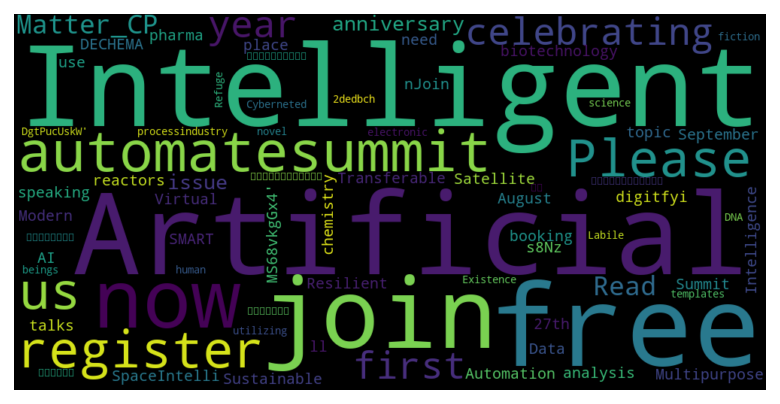

In [72]:
generate_word_cloud(tweets)

     |████████████████████████████████| 162 kB 5.7 MB/s eta 0:00:01
